In [1]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dynamics import ModelDynamics

# Experiments with the graph-based complex system model

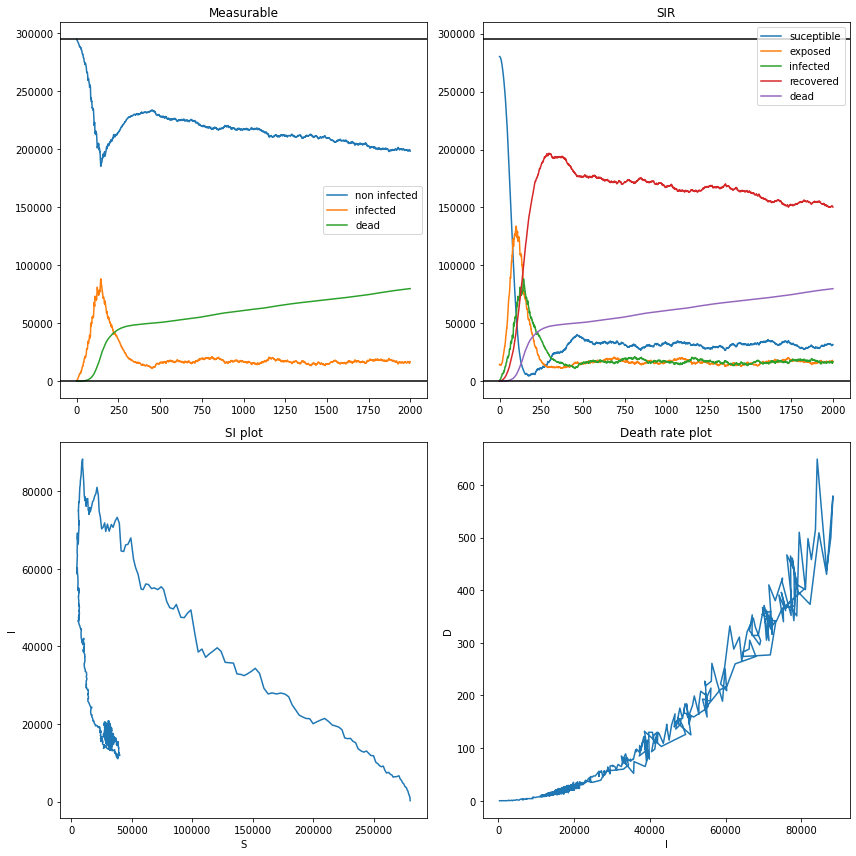

In [13]:
# dyn = ModelDynamics('./config/switzerland.yaml')
dyn = ModelDynamics('./config/single_city.yaml')
dyn.start_epidemic(prop=0.05)
total_history = []
city_history = []
for i in range(2000):
    dyn.step()
    total, cities = dyn.epidemic_parameters()
    total_history.append(total)
    city_history.append(cities)
    
plot()

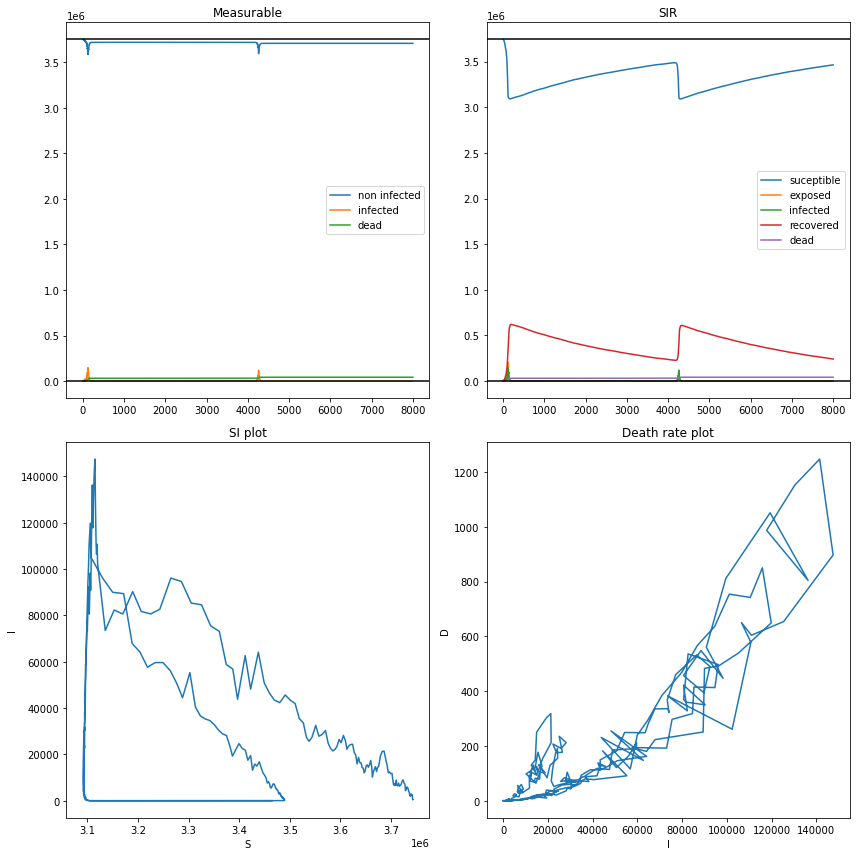

In [43]:
def plot():
    plt.rcParams['figure.figsize'] = [12, 12]
    
    fig, ax = plt.subplots(2,2)
    
    t_suceptible = np.array([t['suceptible'] for t in total_history])
    t_exposed = np.array([t['exposed'] for t in total_history])
    t_infected = np.array([t['infected'] for t in total_history])
    t_recovered = np.array([t['recovered'] for t in total_history])
    t_dead = np.array([t['dead'] for t in total_history])
    # plot 1 "fake SI"
    ax[0,0].plot(np.array(t_suceptible) + np.array(t_recovered) + np.array(t_exposed))
    ax[0,0].plot(t_infected)
    ax[0,0].plot(t_dead)
    ax[0,0].legend(['non infected', 'infected', 'dead'])
    ax[0,0].axhline(0,color='black')
    ax[0,0].axhline(total_history[0]['initial population'],color='black')
    ax[0,0].set_title('Measurable')
    
    # plot 2 "SIR"
    ax[0,1].plot(np.array(t_suceptible))
    ax[0,1].plot(t_exposed)
    ax[0,1].plot(t_infected)
    ax[0,1].plot(np.array(t_recovered))
    ax[0,1].plot(t_dead)
    ax[0,1].legend(['suceptible', 'exposed', 'infected', 'recovered', 'dead'])
    ax[0,1].axhline(0,color='black')
    ax[0,1].axhline(total_history[0]['initial population'],color='black')
    ax[0,1].set_title('SIR')
    
    # plot 3 "Phase plane 1"
    ax[1,0].plot(np.array(t_suceptible),t_infected)
    ax[1,0].set_xlabel('S')
    ax[1,0].set_ylabel('I')
    ax[1,0].set_title('SI plot')
    
    # plot 3 "Death rate 1"
    ax[1,1].plot(t_infected[1:],t_dead[1:]-t_dead[0:-1])
    ax[1,1].set_xlabel('I')
    ax[1,1].set_ylabel('D')
    ax[1,1].set_title('Death rate plot')
    
    fig.tight_layout()
    
    plt.show()
    
    
plot()

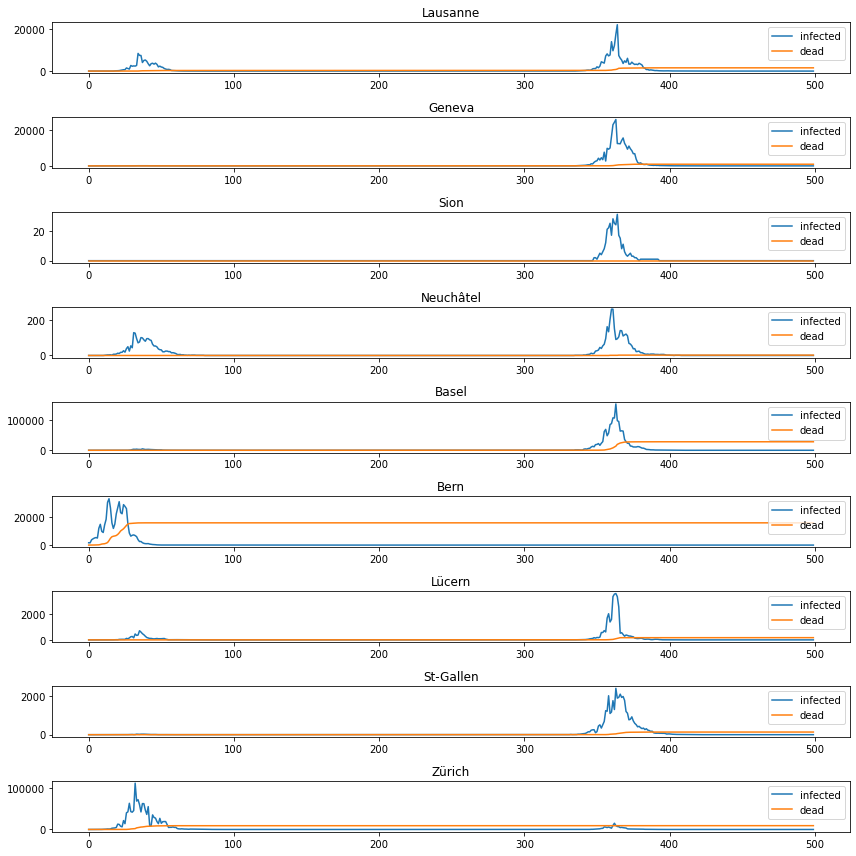

In [153]:
plt.rcParams['figure.figsize'] = [12, 12]

fig, ax = plt.subplots(len(city_history[0].keys()),1)
i = 0
for c in city_history[0].keys():
    c_suceptible = [h[c]['suceptible'] for h in city_history]
    c_infected = [h[c]['infected'] for h in city_history]
    c_recovered = [h[c]['recovered'] for h in city_history]
    c_dead = [h[c]['dead'] for h in city_history]
    # ax[i//2,i%2].plot(c_suceptible)
    # ax[i].plot(np.array(c_recovered)+np.array(c_suceptible))
    ax[i].plot(c_infected)
    ax[i].plot(c_dead)
    ax[i].legend(['infected', 'dead'], loc='upper right')
    ax[i].set_title(c)
    i+= 1
fig.tight_layout()

# Experiments with the graph-based complex system model

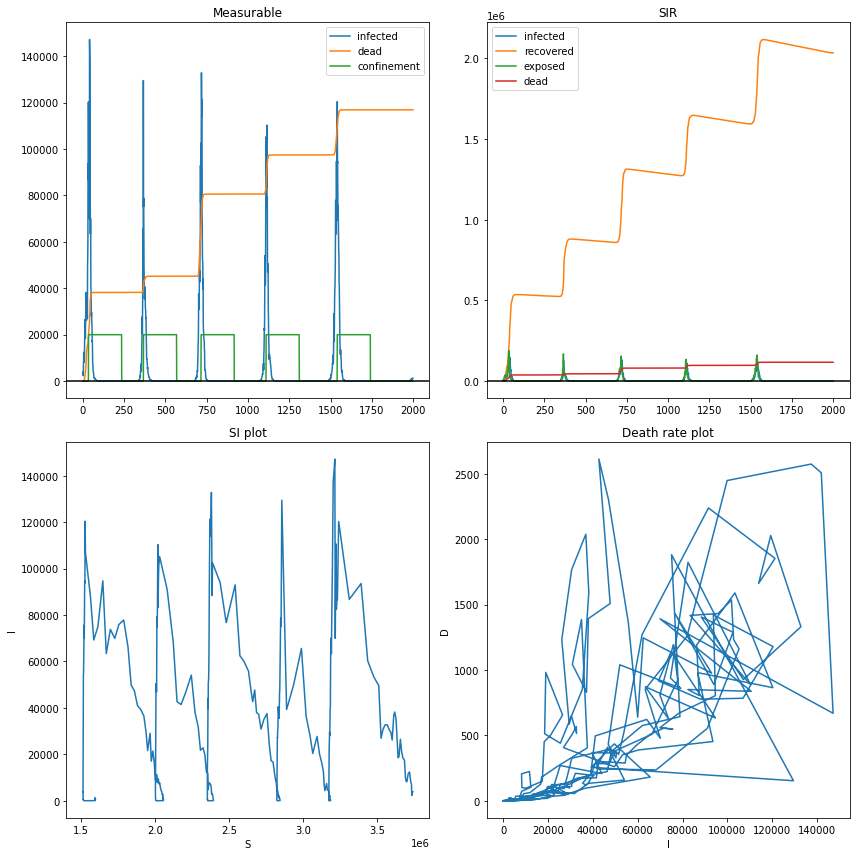

In [172]:
dyn = ModelDynamics('./config/switzerland.yaml')
# dyn = ModelDynamics('./config/single_city.yaml')
total_history = []
city_history = []
confinement_history = []


def plot():
    plt.rcParams['figure.figsize'] = [12, 12]
    
    fig, ax = plt.subplots(2,2)
    
    t_suceptible = np.array([t['suceptible'] for t in total_history])
    t_infected = np.array([t['infected'] for t in total_history])
    t_recovered = np.array([t['recovered'] for t in total_history])
    t_exposed = np.array([t['exposed'] for t in total_history])
    t_dead = np.array([t['dead'] for t in total_history])
    # plot 1 "fake SI"
    # ax[0,0].plot(np.array(t_suceptible) + np.array(t_recovered))
    ax[0,0].plot(t_infected)
    ax[0,0].plot(t_dead)
    ax[0,0].plot(np.array(confinement_history)*20000)
    ax[0,0].legend(['infected', 'dead', 'confinement'])
    ax[0,0].axhline(0,color='black')
    # ax[0,0].axhline(total_history[0]['initial population'],color='black')
    ax[0,0].set_title('Measurable')
    
    # plot 2 "SIR"
    # ax[0,1].plot(np.array(t_suceptible))
    ax[0,1].plot(t_infected)
    ax[0,1].plot(np.array(t_recovered))
    ax[0,1].plot(np.array(t_exposed))
    ax[0,1].plot(t_dead)
    ax[0,1].legend(['infected', 'recovered', 'exposed', 'dead'])
    ax[0,1].axhline(0,color='black')
    # ax[0,1].axhline(total_history[0]['initial population'],color='black')
    ax[0,1].set_title('SIR')
    
    # plot 3 "Phase plane 1"
    ax[1,0].plot(np.array(t_suceptible),t_infected)
    ax[1,0].set_xlabel('S')
    ax[1,0].set_ylabel('I')
    ax[1,0].set_title('SI plot')
    
    # plot 3 "Death rate 1"
    ax[1,1].plot(t_infected[1:],t_dead[1:]-t_dead[0:-1])
    ax[1,1].set_xlabel('I')
    ax[1,1].set_ylabel('D')
    ax[1,1].set_title('Death rate plot')
    
    fig.tight_layout()
    
    plt.show()
    
dyn.start_epidemic(prop=0.05)
confinement_time = 200
timer = -1


for i in range(2000):
    if total['infected']>100000 or timer >= 0:
            if timer == -1:
                timer = confinement_time
            timer -= 1
            dyn.step(confine=True)
            confinement_history.append(1.0)    
    else:
        dyn.step()
        confinement_history.append(0)
        
    total, cities = dyn.epidemic_parameters()
    total_history.append(total)
    city_history.append(cities)
    
plot()

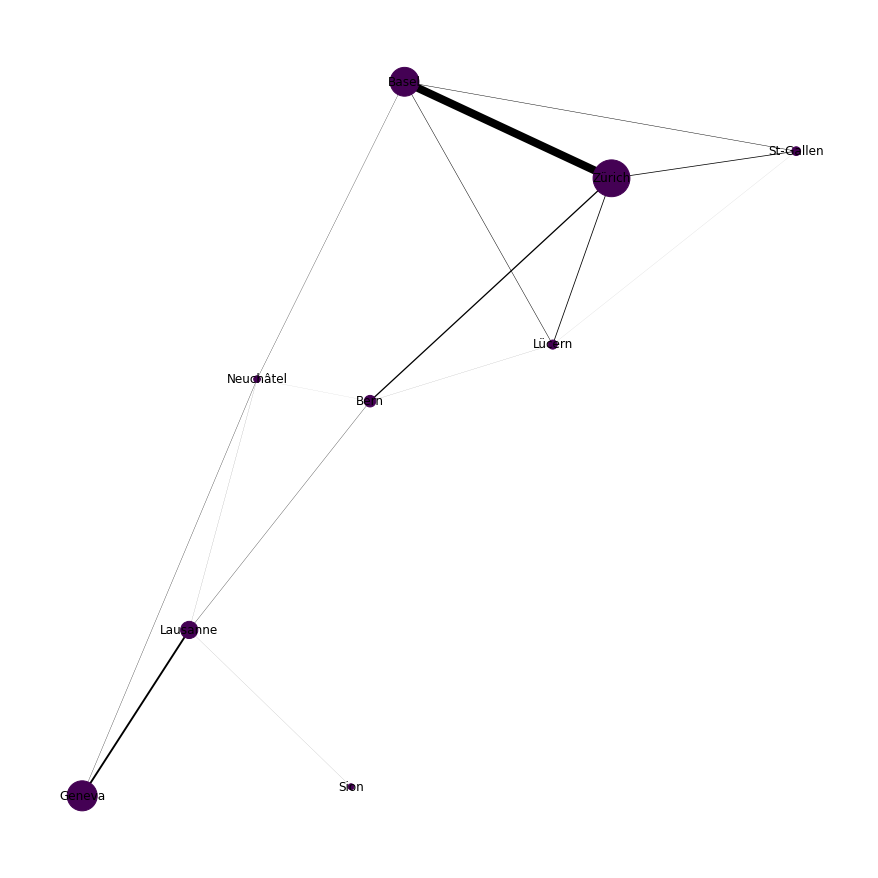

In [170]:
from matplotlib import cm
import matplotlib.animation as pltan
from matplotlib.colors import ListedColormap
inferno = cm.get_cmap('inferno', 256)# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)
newcmp = ListedColormap(inferno(np.linspace(0, 1e-3, 256)))

fig, ax = plt.subplots(1)

def update(t, ax):
    ax.clear()
    cmap = []
    for c in dyn.cities:
        cmap.append(np.log(city_history[t][c]['infected']/city_history[-1][c]['initial population']+1))
    plt.clf()
    nx.draw(dyn.map,
            with_labels=True,
            pos=dyn.pos_map,
            node_size=[dyn.map.nodes[n]['pop']/1000 for n in dyn.map.nodes()], 
            width=[dyn.map.edges[e]['tau']*10 for e in dyn.map.edges()],
            node_color=cmap,
            )

# ani = pltan.FuncAnimation(fig, update, frames=6, interval=10, repeat=True)
# plt.savefig('a.gif')
update(450, ax)
plt.show()


In [123]:
total_history[20]

{'suceptible': 3634636,
 'exposed': 63082,
 'infected': 10287,
 'recovered': 36771,
 'dead': 5043,
 'initial population': 3749837}